<a href="https://colab.research.google.com/github/shrau-1734/CodSoft-MachineLearning-TASK-2-CREDIT-CARD-FRAUD-DETECTION/blob/main/timeseries_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn torch wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
import os
print(os.getcwd())  # Prints the current working directory


/content


In [9]:
print(os.listdir())  # Lists all files in the current directory


['.config', 'sample_data']


In [2]:
from google.colab import files
uploaded = files.upload()


Saving test.xlsx to test.xlsx
Saving train.xlsx to train.xlsx


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
train_data = pd.read_excel(r'train.xlsx')
test_data = pd.read_excel(r'test.xlsx')

# Check data types
print(train_data.dtypes)

# Convert date columns to numeric timestamps
if 'date_column' in train_data.columns:  # Change 'date_column' to actual column name
    train_data['date_column'] = pd.to_datetime(train_data['date_column']).astype(int) // 10**9
    test_data['date_column'] = pd.to_datetime(test_data['date_column']).astype(int) // 10**9

# Convert categorical columns using one-hot encoding
train_data = pd.get_dummies(train_data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

# Ensure both datasets have the same columns
train_data, test_data = train_data.align(test_data, join='inner', axis=1)

# Standardize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convert back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=train_data.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_data.columns)

# Print success message
print("Data preprocessing completed successfully!")


Time          object
year           int64
month          int64
day            int64
Sl_cor       float64
so_m3        float64
thetao_m3    float64
M_eta        float64
M_xi         float64
V_eta        float64
V_xi         float64
tp           float64
dtype: object
Data preprocessing completed successfully!


In [5]:
def create_sequences(data, seq_length=96, pred_length=14):
    X, Y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length:i + seq_length + pred_length])
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(train_scaled)
X_test, Y_test = create_sequences(test_scaled)
print("Training shape:", X_train.shape, Y_train.shape)
print("Testing shape:", X_test.shape, Y_test.shape)


Training shape: (278, 96, 11) (278, 14, 11)
Testing shape: (254, 96, 11) (254, 14, 11)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConditionalDDPM(nn.Module):
    def __init__(self, input_dim, seq_length, pred_length):
        super(ConditionalDDPM, self).__init__()
        self.input_dim = input_dim
        self.seq_length = seq_length
        self.pred_length = pred_length

        self.encoder = nn.Sequential(
            nn.Linear(input_dim * seq_length, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, input_dim * pred_length),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1, self.pred_length, self.input_dim)

model = ConditionalDDPM(input_dim=train_data.shape[1], seq_length=96, pred_length=14)


In [7]:
import wandb

wandb.init(project="time-series-forecasting-ddpm")

config = wandb.config
config.learning_rate = 0.001
config.epochs = 100
config.batch_size = 32

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = nn.MSELoss()

# Logging Model
wandb.watch(model)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shravanimotarwar (shravanimotarwar-dr-d-y-patil-institute-of-engineering-m) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
def train_model(model, X_train, Y_train):
    model.train()
    for epoch in range(config.epochs):
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

        wandb.log({"epoch": epoch, "loss": loss.item()})

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{config.epochs}], Loss: {loss.item():.4f}")

train_model(model, X_train, Y_train)


Epoch [0/100], Loss: 0.9892
Epoch [10/100], Loss: 0.6939
Epoch [20/100], Loss: 0.6264
Epoch [30/100], Loss: 0.5829
Epoch [40/100], Loss: 0.5532
Epoch [50/100], Loss: 0.5321
Epoch [60/100], Loss: 0.5157
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.4957
Epoch [90/100], Loss: 0.4896


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_test, Y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        predictions = model(X_test_tensor).numpy()

        # Univariate (last feature)
        mse_univariate = mean_squared_error(Y_test[:, :, -1], predictions[:, :, -1])
        mae_univariate = mean_absolute_error(Y_test[:, :, -1], predictions[:, :, -1])

        # Multivariate (all features)
        mse_multivariate = mean_squared_error(Y_test.reshape(-1), predictions.reshape(-1))
        mae_multivariate = mean_absolute_error(Y_test.reshape(-1), predictions.reshape(-1))

    print(f"Univariate - MSE: {mse_univariate:.4f}, MAE: {mae_univariate:.4f}")
    print(f"Multivariate - MSE: {mse_multivariate:.4f}, MAE: {mae_multivariate:.4f}")

evaluate_model(model, X_test, Y_test)


Univariate - MSE: 0.5485, MAE: 0.4702
Multivariate - MSE: 2.4778, MAE: 0.9972


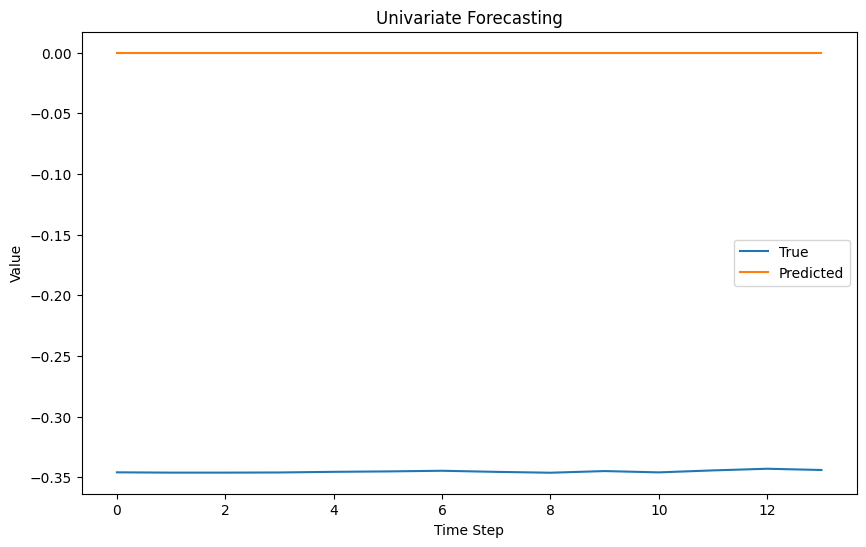

In [11]:
import matplotlib.pyplot as plt


index = 0
true_values = Y_test[index][:, -1]
predicted_values = model(torch.tensor(X_test[index:index+1], dtype=torch.float32)).detach().numpy()[0][:, -1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(true_values)), true_values, label="True")
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Univariate Forecasting")
plt.show()
